In [1]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import time
from pandas import ExcelWriter
from pandas import ExcelFile
from pprint import pprint
from scipy.stats import linregress
from datetime import timedelta
from mpl_toolkits.basemap import Basemap

In [19]:
fileordprod = "./data/brazilian-ecommerce/olist_order_items_dataset.csv"
fileordcusttime = "./data/brazilian-ecommerce/olist_orders_dataset.csv"
fileprodcat = "./data/brazilian-ecommerce/olist_products_dataset.csv"
fileprodtransl = "./data/brazilian-ecommerce/product_category_name_translation.csv"
filecustzip = "./data/brazilian-ecommerce/olist_customers_dataset.csv"
filezipcoord = "./data/brazilian-ecommerce/olist_geolocation_dataset.csv"

ordprod = pd.read_csv(fileordprod)#[['order_id', 'product_id', 'price']]
ordcusttime= pd.read_csv(fileordcusttime)#[['order_id', 'customer_id', 'order_purchase_timestamp']]
prodcat = pd.read_csv(fileprodcat)#[['product_id', 'product_category_name']]
prodtransl = pd.read_csv(fileprodtransl)
custzip = pd.read_csv(filecustzip)[['customer_id','customer_zip_code_prefix']]
zipcoord = pd.read_csv(filezipcoord)[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]

zipcoord = zipcoord.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'}).drop_duplicates(subset = 'customer_zip_code_prefix')

mergedf = pd.merge(ordcusttime, ordprod, on = 'order_id',how= 'left')
mergedf = pd.merge(mergedf, prodcat, on = 'product_id', how = 'left')
mergedf = pd.merge(mergedf, prodtransl, on = 'product_category_name', how = 'left')
mergedf = pd.merge(mergedf, custzip, on = 'customer_id', how = 'left')
mergedf = pd.merge(mergedf, zipcoord, on = 'customer_zip_code_prefix' , how = 'left')

renamecolumns = {
    'order_purchase_timestamp': 'order_time',
    'product_category_name_english': 'category'
}
mergedf = mergedf.rename(columns = renamecolumns)

#minus one day
mergedf["date_time"]= pd.to_datetime(mergedf['order_time']) - timedelta(days=1)

#converted to MM/YY Format
mergedf['YYYY'] = pd.DatetimeIndex(mergedf['date_time']).year
mergedf['MM'] = pd.DatetimeIndex(mergedf['date_time']).month
mergedf['month'] = pd.to_datetime(mergedf['date_time'])
mergedf['day'] = mergedf['month'].dt.strftime('%m/%d/%y')
mergedf['month'] = mergedf['month'].dt.strftime('%m/%y')

#Rid of black friday
mergedf = mergedf.loc[mergedf['day'] != '11/23/17']

#Add lat lon bins
lngbin = np.arange(min(mergedf['geolocation_lng']), max(mergedf['geolocation_lng']), 1)
latbin = np.arange(min(mergedf['geolocation_lat']), max(mergedf['geolocation_lat']), 1)

lngbinlabel = []
latbinlabel = []

for lng in range(0, len(lngbin) - 1):
    lngbinlabel.append(lngbin[lng] + (lngbin[lng+1] - lngbin[lng])/2)
        
for lat in range(0, len(latbin) - 1):
    latbinlabel.append(latbin[lat] + (latbin[lat+1] - latbin[lat])/2)

mergedf['lngbin'] = pd.cut(mergedf['geolocation_lng'], lngbin, labels=lngbinlabel)
mergedf['latbin'] = pd.cut(mergedf['geolocation_lat'], latbin, labels=latbinlabel)

urlBOV = "https://www.quandl.com/api/v3/datasets/BCB/7.json?api_key=2vRuu5GNchksqBdcAHzc"
responseBOV = requests.get(urlBOV).json()


BOV_df = pd.DataFrame(responseBOV['dataset']['data'])

BOV_df = BOV_df.rename(index=str, columns={0: "day", 1: "BOV"})

BOV_df['day'] = pd.to_datetime(BOV_df['day'])
BOV_df['day'] = BOV_df['day'].dt.strftime('%m/%d/%y')
BOV_df['BOV'] = pd.to_numeric(BOV_df['BOV'])
BOV_df = BOV_df.sort_values(by = 'day', ascending = True)
# BOV_df['BOVdiff'] = BOV_df['BOV'].diff(periods = days)
# BOV_df['BOVma'] = BOV_df['BOV'].rolling(window = days).mean()

metriclist = ['BOV']#, 'BOVdiff', 'BOVma']
mergedf = pd.merge(mergedf, BOV_df, on = 'day', how = 'left')

new_categories = {'fashion_clothing': ['perfumery', 'luggage_accessories','watches_gifts','fashion_underwear_beach','fashion_bags_accessories','fashion_shoes','fashion_male_clothing','fashion_sport','fashio_female_clothing','fashion_childrens_clothes'],
                  'home_furniture': ['housewares','art','arts_and_craftmanship','furniture_decor','office_furniture','bed_bath_table','home_confort','furniture_bedroom','kitchen_dining_laundry_garden_furniture','home_comfort_2','furniture_mattress_and_upholstery'],
                  'construction_tools': ['garden_tools','construction_tools_construction','construction_tools_lights','construction_tools_garden','construction_tools_safety','home_construction','construction_tools_tools'],
                  'electronics': ['computers_accessories','telephony','electionics','cds_dvds_musicals','consoles_games','audio','tablets_printing_image','computers','dvds_blu_ray','music'],
                  'food_drink': ['food','drinks','food_drink','la_cuisine'],
                  'books': ['books_general_interest','books_imported','books_technical'],
                  'appliances': ['air_conditioning','small_appliances','home_appliances','home_appliances_2','small_appliances_home_oven_and_coffee'],
                  'auto': ['auto'],
                  'industry':['agro_industry_and_commerce','industry_commerce_and_business'],
                  'other':['pet_shop','stationary','toys','baby','cool_stuff','sports_leisure','diapers_and_hygeine','signaling_and_security','party_supplies','cine_photo','market_place','musical_instruments','christmas_supplies']}


new_dict = {}
for key,valuelist in new_categories.items():
    for v in valuelist:
        new_dict[v] = key

mergedf['category'] = mergedf.category.replace(new_dict)

mergedf.head()

(7212, 2)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status           order_time    order_approved_at  \
0    delivered  2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered  2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered  2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered  2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered  2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id   ...    geolocation_lat geolocation_lng  \
0  87285b34884572647811a353c7ac498a   ...         -23.574809      -46.587471   
1  595fac2a385ac33a80bd5114aec74eb8   ...         -12.169860      -44.988369   
2  aa4383b373c6aca5d8797843e5594415   ...         -16.746337      -48.514624   
3  d0b61bfb1de832b15ba9d266ca96e5b0   ...          -5.767733      -35.275467   
4  65266b2da20d04dbe00c5c2d3bb7859e   ...         -23.675037      -46.524784   

            date_time  YYYY  MM  month       day     lngbin     latbin  \
0 2017-10-01 10:56:33  2017  10  10/17  10/01/17 -46.166706 -23.105374   
1 2018-07-23 20:41:37  2018   7  07/18  07/23/18 -45.166706 -12.105374   
2 2018-08-07 08:38:49  2018   8  08/18  08/07/18 -48.166706 -17.105374   
3 2017-11-17 19:28:06  2017  11  11/17  11/17/17 -35.166706  -6.105374   
4 2018-02-12 21:18:39  2018   2  02/18  02/12/18 -46.166706 -24.105374   

       BOV  
0      NaN  
1  77996.0  
2  80346.0  
3  73437.0  
4      NaN  

[5 rows x 34 columns]

In [3]:
#commented out because it lags when rerunning all 

#save to excel file 

# writer = ExcelWriter('output.xlsx')
# mergedf.to_excel(writer,'Sheet1',index=False)
# writer.save()

In [4]:
home_furniture = mergedf['price'][mergedf['category']=='home_furniture'].sum()
fashion_clothing = mergedf['price'][mergedf['category']=='fashion_clothing'].sum()
construction_tools = mergedf['price'][mergedf['category']=='construction_tools'].sum()
electronics = mergedf['price'][mergedf['category']=='electronics'].sum()
food_drink = mergedf['price'][mergedf['category']=='food_drink'].sum()
books = mergedf['price'][mergedf['category']=='books'].sum()
appliances = mergedf['price'][mergedf['category']=='appliances'].sum()

auto = mergedf['price'][mergedf['category']=='auto'].sum()
industry = mergedf['price'][mergedf['category']=='industry'].sum()
other = mergedf['price'][mergedf['category']=='other'].sum()
#data['duration'][data['item'] == 'call'].sum()

total_spend = home_furniture + fashion_clothing + construction_tools + electronics + food_drink + books + appliances + auto + industry + other

category_spend = {home_furniture:'home_furniture',
                        fashion_clothing:'fashion_clothing',
                        construction_tools:'construction_tools',
                        electronics:'electronics',
                        food_drink:'food_drink',
                        books:'books',
                        appliances:'appliances',
                        auto:'auto',
                        appliances:'industry',
                        other:'other'
                       }

In [5]:
groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()

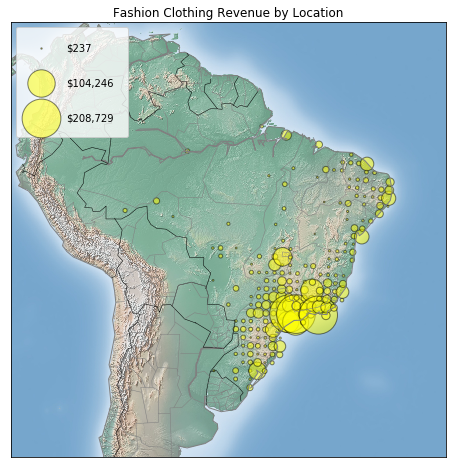

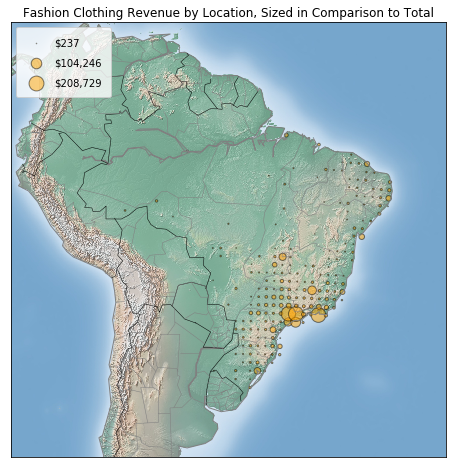

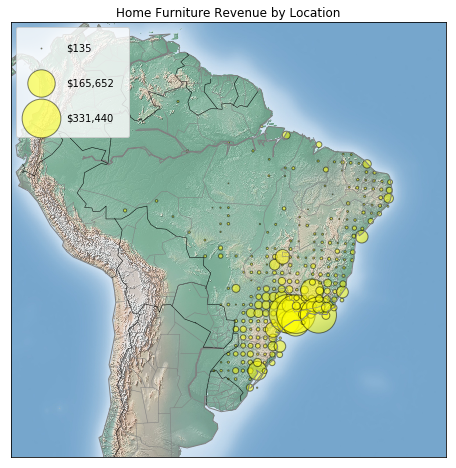

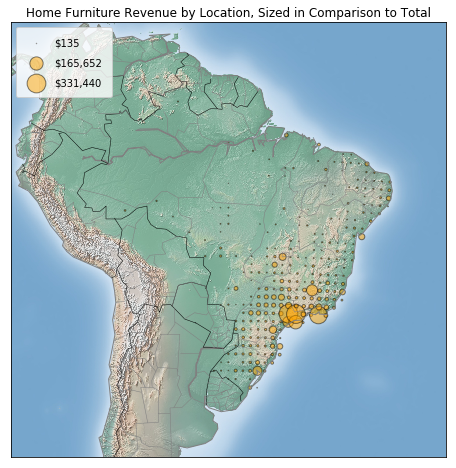

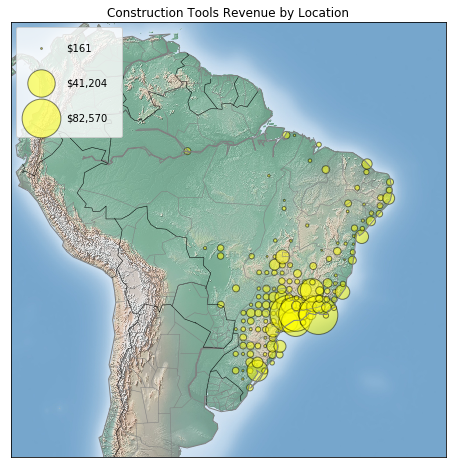

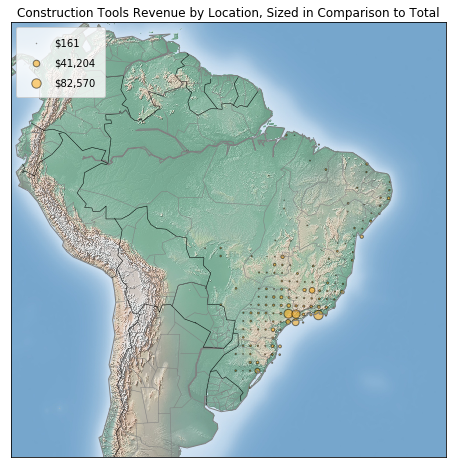

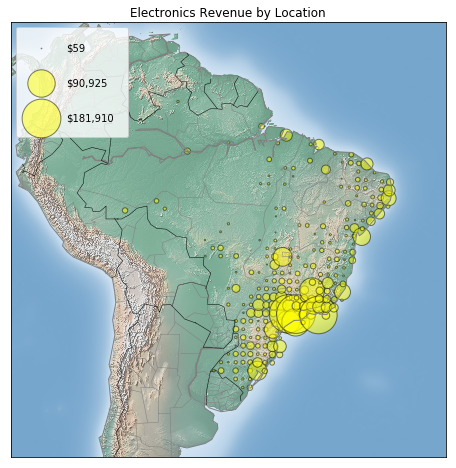

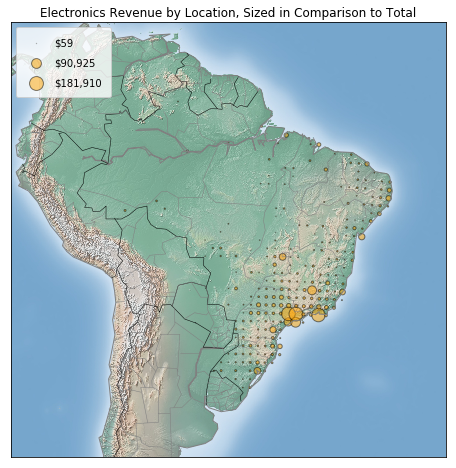

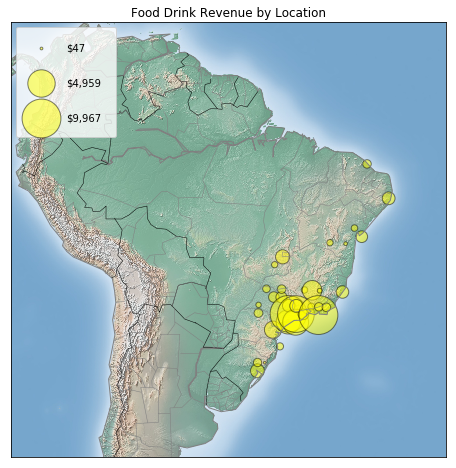

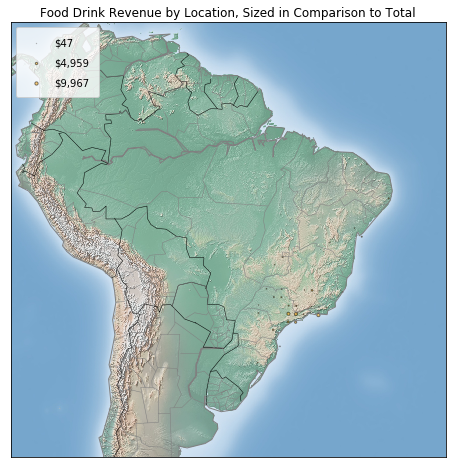

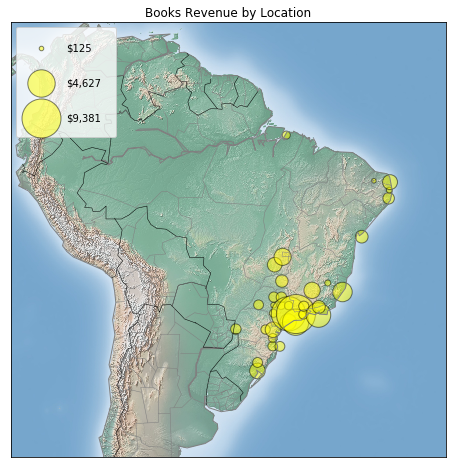

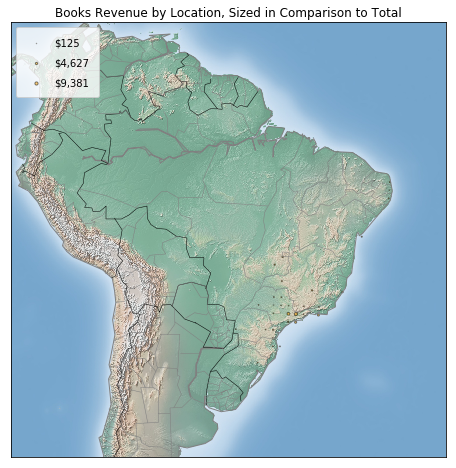

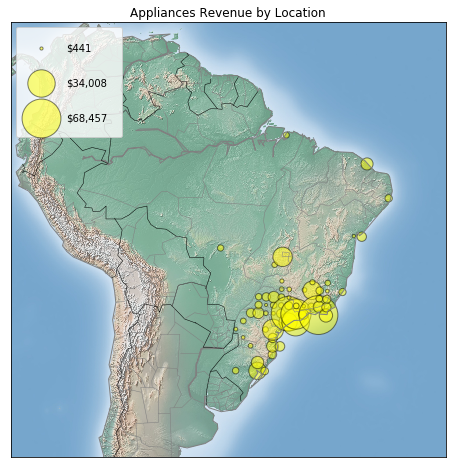

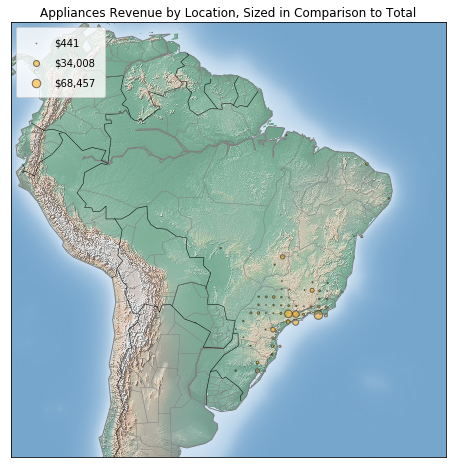

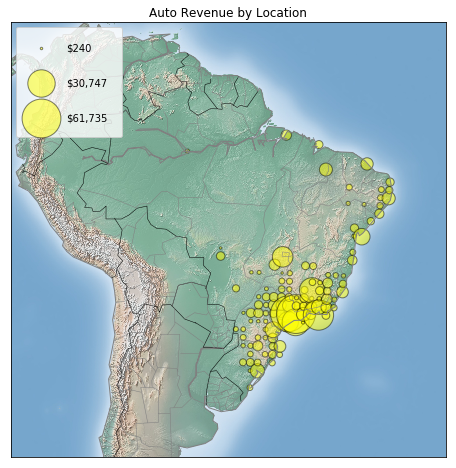

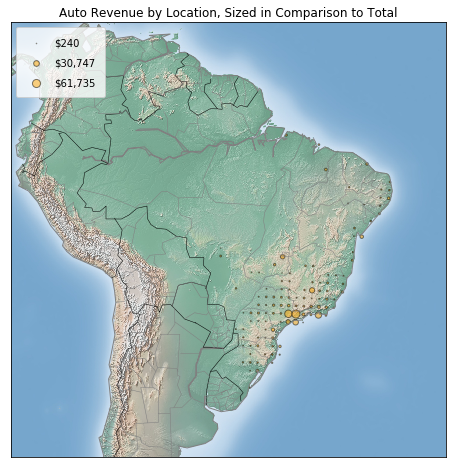

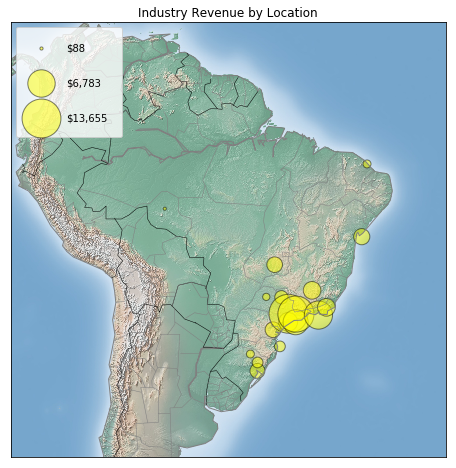

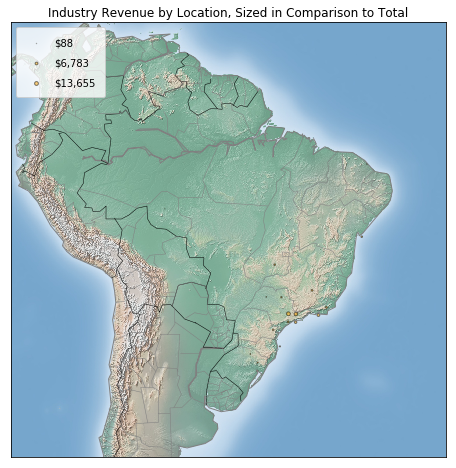

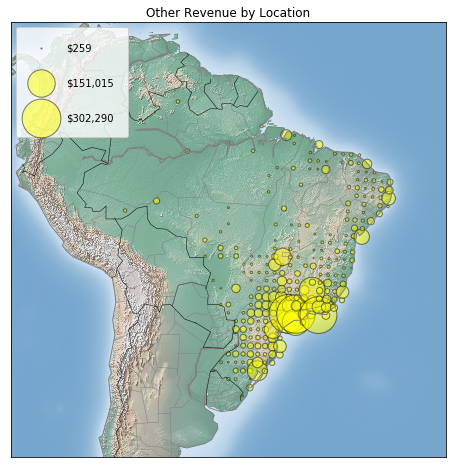

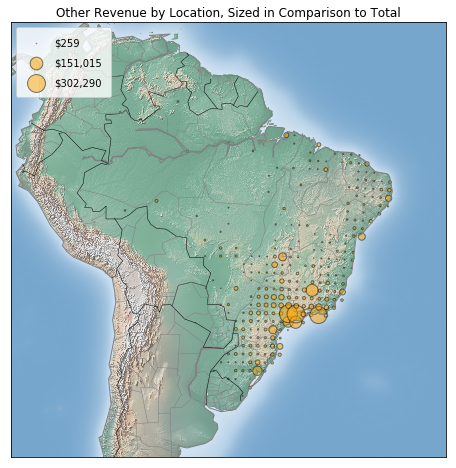

         lngbin    latbin category  order_item_id     price  freight_value  \
1663 -35.166706 -6.105374    other           74.0   7235.14        1678.06   
1645 -35.166706 -8.105374    other          272.0  36889.18        8107.31   
1635 -35.166706 -9.105374    other            7.0   1347.44         253.17   
1654 -35.166706 -7.105374    other           74.0  12117.40        2366.84   
1630 -36.166706 -6.105374    other            7.0    611.51         283.07   

      product_name_lenght  product_description_lenght  product_photos_qty  \
1663               2808.0                     52715.0               136.0   
1645              11778.0                    238022.0               593.0   
1635                331.0                      9626.0                14.0   
1654               3155.0                     69580.0               161.0   
1630                355.0                      8545.0                17.0   

      product_weight_g  product_length_cm  product_height_cm  \
1663

In [6]:


minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10
dividebytotal = (max(groupdf['price']) - min(groupdf['price']))/1500

for cat in new_categories.keys():
    
    ###COMPARED TO SELF###
    groupdf = mergedf.groupby(['lngbin', 'latbin', 'category'])
    groupdf = groupdf.sum()
    groupdf = groupdf.loc[groupdf['price'].isnull() == False]
    groupdf = groupdf.loc[groupdf['order_item_id'] > 5]
    groupdf = groupdf.reset_index()
    
    groupdf = groupdf.loc[groupdf['category'] == cat]
    
    dividebyeach = (max(groupdf['price']) - min(groupdf['price']))/1500
    
    lon = list(groupdf['lngbin'])
    lat = list(groupdf['latbin'])
    revenue = list(groupdf['price']/dividebyeach)

    # 1. Draw the map background
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution='c', 
                lat_0=-14.1, lon_0=-55.2,
                width=6000000, height=6000000)
    m.shadedrelief()
    m.drawcoastlines(color='gray')
    m.drawcountries(color='black')
    m.drawstates(color='gray')

    # 2. scatter city data, with color reflecting population
    # and size reflecting area
    m.scatter(lon, lat, latlon=True, s=revenue, alpha=0.5, edgecolor = 'black', color = 'yellow')
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebyeach)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebyeach)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebyeach)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper left',
        scatterpoints=1, labelspacing = 2.5, borderpad = 1.5, handletextpad = 1.5)
    LH = leg.legendHandles
    LH[0].set_color('yellow')
    LH[1].set_color('yellow')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('yellow')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location')
    plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location.png')
    plt.show()
    
    ###COMPARED TO TOTAL###
    
    lon = list(groupdf['lngbin'])
    lat = list(groupdf['latbin'])
    revenue = list(groupdf['price']/dividebytotal)

    # 1. Draw the map background
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution='c', 
                lat_0=-14.1, lon_0=-55.2,
                width=6000000, height=6000000)
    m.shadedrelief()
    m.drawcoastlines(color='gray')
    m.drawcountries(color='black')
    m.drawstates(color='gray')

    # 2. scatter city data, with color reflecting population
    # and size reflecting area
    m.scatter(lon, lat, latlon=True, s=revenue, alpha=0.5, edgecolor = 'black', color = 'orange')
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper left',
        scatterpoints=1, labelspacing = 1, borderpad = 1)
    LH = leg.legendHandles
    LH[0].set_color('orange')
    LH[1].set_color('orange')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('orange')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total')
    plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total.png')
    
    plt.show()
    

print(groupdf.sort_values(by = ['lngbin'], ascending = False).head())

Text(35.0, 0.5, 'Total Spend')

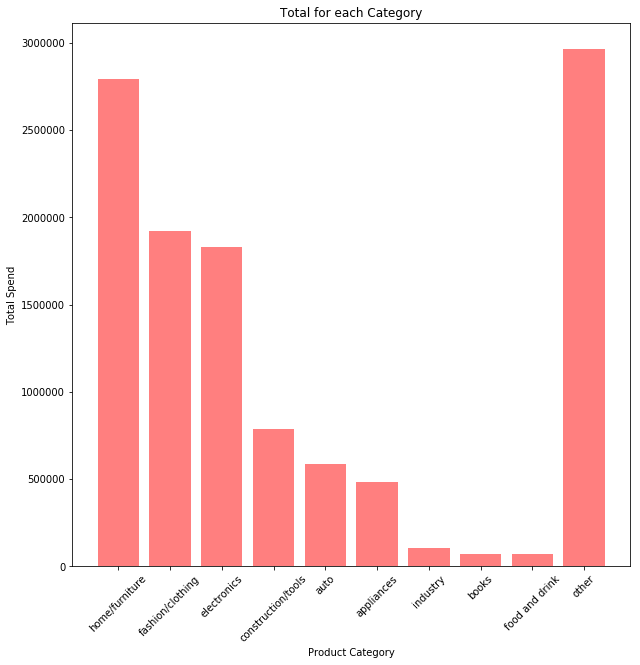

In [20]:
from matplotlib.pyplot import figure
x_axis = ['home/furniture', 'fashion/clothing', 'electronics', 'construction/tools', 'auto', 'appliances', 'industry', 'books', 'food and drink', 'other']
sizes =[home_furniture, fashion_clothing, electronics, construction_tools, auto, appliances, industry, books, food_drink, other]
fig = plt.figure(figsize=(10, 10))
plt.bar(x_axis, sizes, color='r', alpha=0.5, align="center", orientation = 'vertical')
plt.xticks(rotation = 45)
# Save Figure
plt.savefig("./Images/total_spend.png")
plt.title("Total for each Category")
plt.xlabel("Product Category")
plt.ylabel("Total Spend")

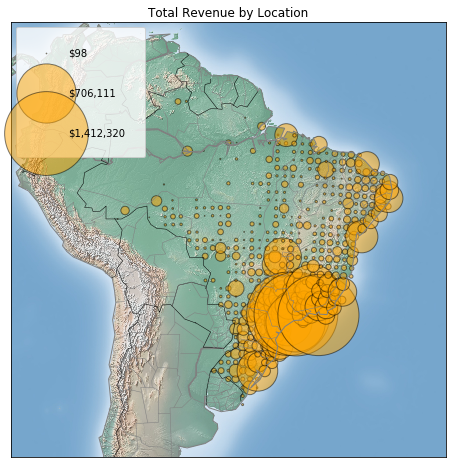

In [8]:
# Extract the data we're interested in
###TOTAL###
minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10
dividebytotal = (max(groupdf['price']) - min(groupdf['price']))/1500


groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()

lon = list(groupdf['lngbin'])
lat = list(groupdf['latbin'])
revenue = list(groupdf['price']/dividebytotal)

# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='c', 
            lat_0=-14.1, lon_0=-55.2,
            width=6000000, height=6000000)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, s=revenue, alpha=0.5, edgecolor = 'black', color = 'orange')


# 3. create colorbar and legend
marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
legend_markers = [marker1, marker2, marker3]
labels = [
    '$' + str("{:,}".format(int(groupdf['price'].min()))),
    '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
    '$' + str("{:,}".format(int(groupdf['price'].max())))
    ]
leg = plt.legend(handles=legend_markers, labels=labels, loc='upper left',
    scatterpoints=1, labelspacing = 3, borderpad = 2, handletextpad = 1.25)
LH = leg.legendHandles
LH[0].set_color('orange')
LH[1].set_color('orange')
LH[0].set_alpha(0.5)
LH[1].set_alpha(0.5)
LH[0].set_edgecolor('black')
LH[1].set_edgecolor('black')
LH[2].set_color('orange')
LH[2].set_alpha(0.5)
LH[2].set_edgecolor('black')
# plt.xlim(minlng - marginlng, maxlng + 10 * marginlng)
# plt.ylim(minlat - marginlat, maxlat  + 1 * marginlat)

plt.title('Total Revenue by Location')
plt.savefig('./Graphs/Total Revenue by Location.png')

# make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');

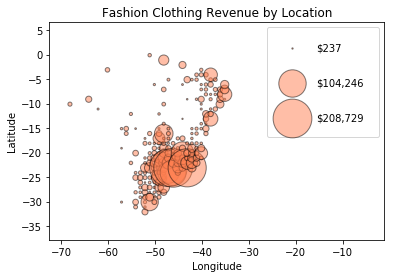

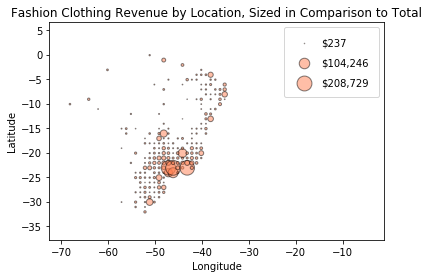

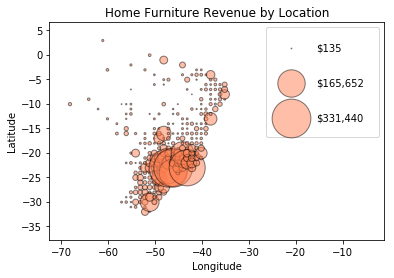

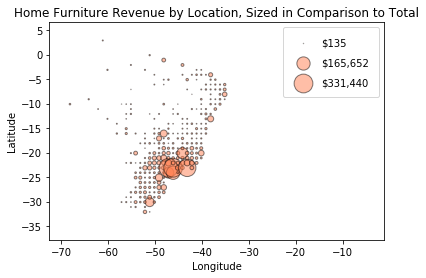

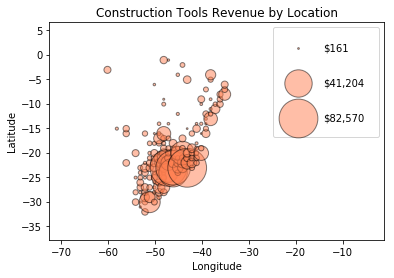

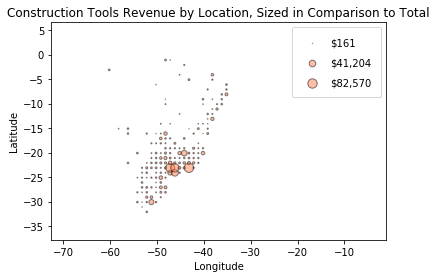

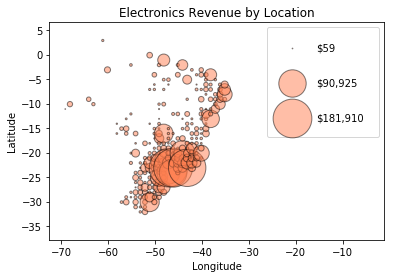

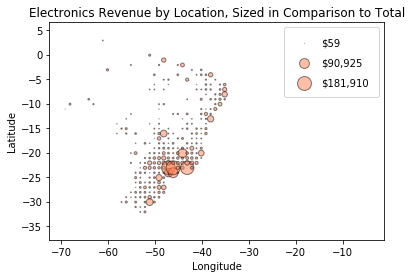

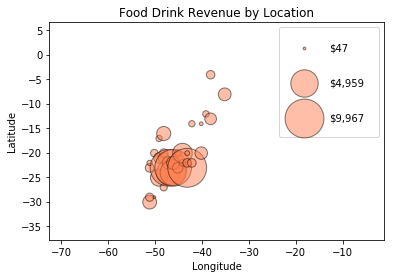

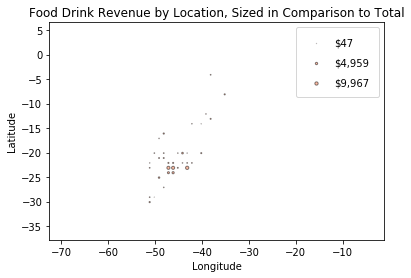

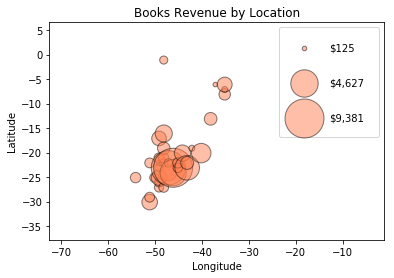

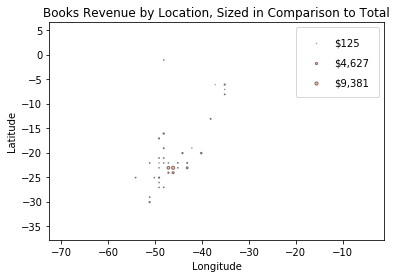

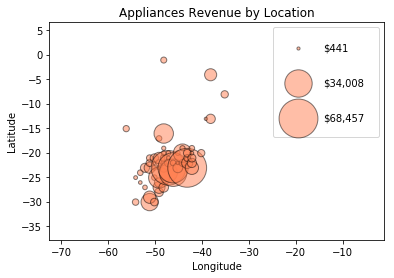

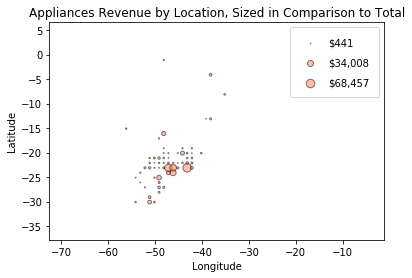

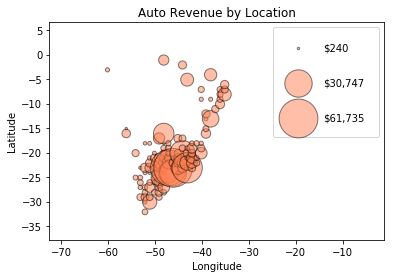

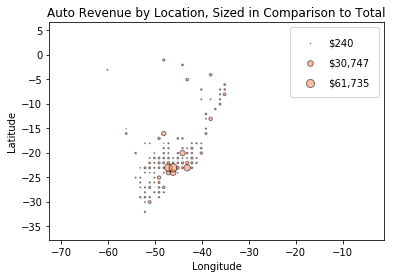

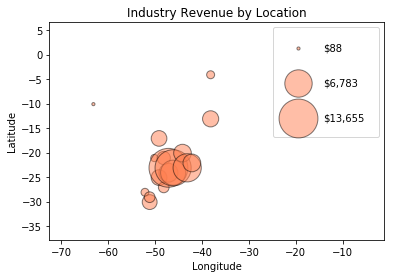

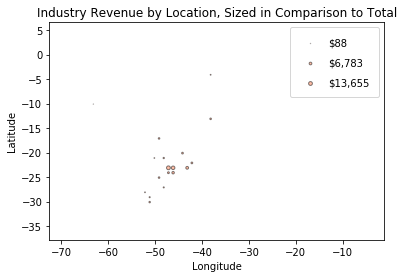

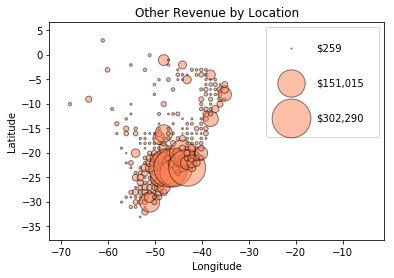

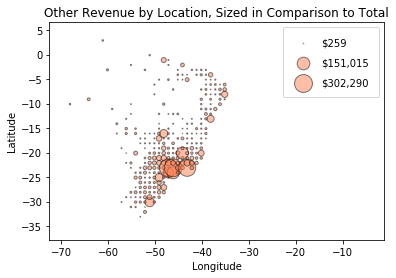

In [9]:
groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()

minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10
dividebytotal = (max(groupdf['price']) - min(groupdf['price']))/1500

for cat in new_categories.keys():
    
    ###COMPARED TO SELF###
    groupdf = mergedf.groupby(['lngbin', 'latbin', 'category'])
    groupdf = groupdf.sum()
    groupdf = groupdf.loc[groupdf['price'].isnull() == False]
    groupdf = groupdf.loc[groupdf['order_item_id'] > 5]
    groupdf = groupdf.reset_index()
    
    groupdf = groupdf.loc[groupdf['category'] == cat]
    
    dividebyeach = (max(groupdf['price']) - min(groupdf['price']))/1500
    plt.scatter(groupdf['lngbin'], groupdf['latbin'], color="coral", edgecolor="black", alpha = 0.5,marker="o", s=groupdf['price']/dividebyeach)
    plt.xlim(minlng - marginlng, maxlng + 10 * marginlng)
    plt.ylim(minlat - marginlat, maxlat  + 1 * marginlat)
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebyeach)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebyeach)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebyeach)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper right',
        scatterpoints=1, labelspacing = 2.5, borderpad = 1.5, handletextpad = 1.5)
    LH = leg.legendHandles
    LH[0].set_color('coral')
    LH[1].set_color('coral')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('coral')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location')
    plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location.png')
    plt.show()
    
    ###COMPARED TO TOTAL###
    
    plt.scatter(groupdf['lngbin'], groupdf['latbin'], color="coral", edgecolor="black", alpha = 0.5,marker="o", s=groupdf['price']/dividebytotal)
    plt.xlim(minlng - marginlng, maxlng + 10 * marginlng)
    plt.ylim(minlat - marginlat, maxlat  + 1 * marginlat)
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper right',
        scatterpoints=1, labelspacing = 1, borderpad = 1)
    LH = leg.legendHandles
    LH[0].set_color('coral')
    LH[1].set_color('coral')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('coral')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total')
    plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total.png')
    
    plt.show()

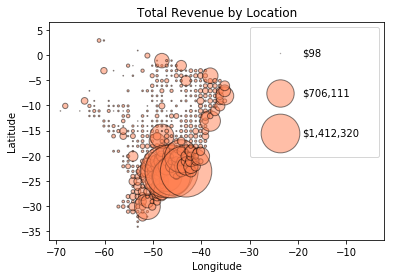

In [10]:
###TOTAL###

minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10


groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()


plt.scatter(groupdf['lngbin'], groupdf['latbin'], color="coral", edgecolor="black", alpha = 0.5,marker="o", s=groupdf['price']/500)
plt.xlim(minlng - marginlng, maxlng + 10 * marginlng)
plt.ylim(minlat - marginlat, maxlat  + 1 * marginlat)

marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
legend_markers = [marker1, marker2, marker3]
labels = [
    '$' + str("{:,}".format(int(groupdf['price'].min()))),
    '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
    '$' + str("{:,}".format(int(groupdf['price'].max())))
    ]
leg = plt.legend(handles=legend_markers, labels=labels, loc='upper right',
    scatterpoints=1, labelspacing = 3, borderpad = 2, handletextpad = 1.25)
LH = leg.legendHandles
LH[0].set_color('coral')
LH[1].set_color('coral')
LH[0].set_alpha(0.5)
LH[1].set_alpha(0.5)
LH[0].set_edgecolor('black')
LH[1].set_edgecolor('black')
LH[2].set_color('coral')
LH[2].set_alpha(0.5)
LH[2].set_edgecolor('black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Total Revenue by Location')
plt.savefig('./Graphs/Total Revenue by Location.png')

plt.show()

R2 = 0.28
Revenue = 0.12 * (BOVESPA Index) + (-5916.12)


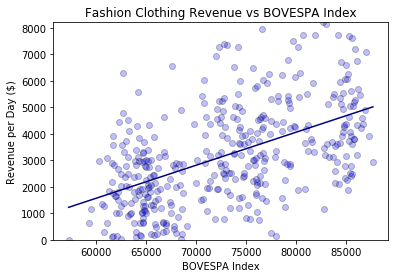

R2 = 0.38
Revenue = 0.18 * (BOVESPA Index) + (-8715.16)


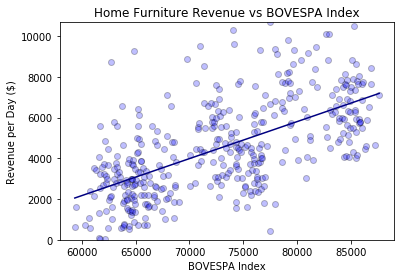

R2 = 0.24
Revenue = 0.05 * (BOVESPA Index) + (-2676.33)


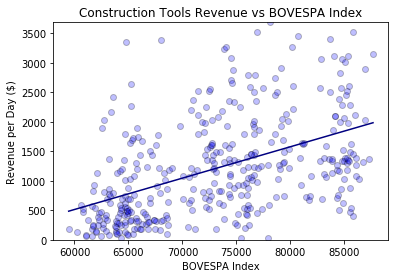

R2 = 0.32
Revenue = 0.14 * (BOVESPA Index) + (-7335.77)


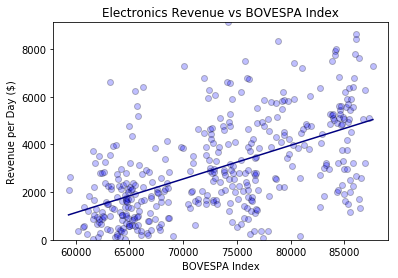

R2 = 0.07
Revenue = 0.0 * (BOVESPA Index) + (-167.18)


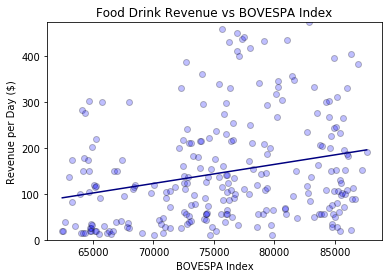

R2 = 0.01
Revenue = 0.0 * (BOVESPA Index) + (43.18)


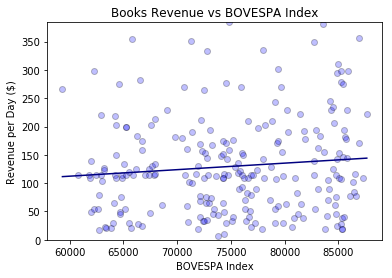

R2 = 0.15
Revenue = 0.03 * (BOVESPA Index) + (-1596.31)


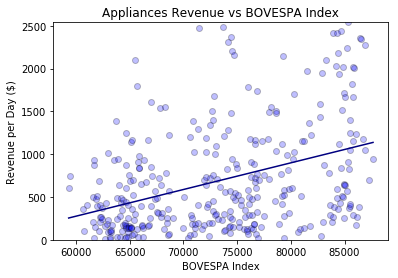

R2 = 0.22
Revenue = 0.04 * (BOVESPA Index) + (-2182.09)


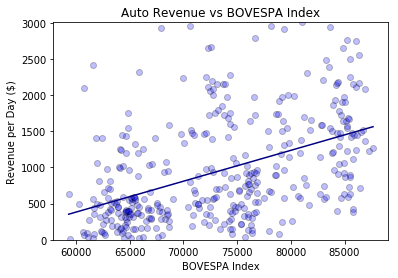

R2 = 0.01
Revenue = 0.01 * (BOVESPA Index) + (-58.64)


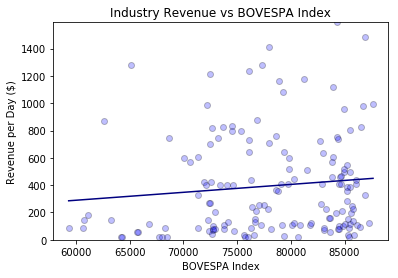

R2 = 0.32
Revenue = 0.17 * (BOVESPA Index) + (-8001.37)


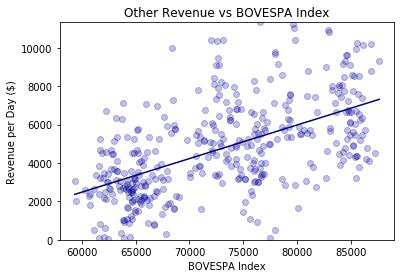

In [11]:
#BY CATEGORIES
for metric in metriclist:
    for cat in new_categories.keys():
        groupdf = mergedf.groupby([metric, 'category'])
        groupdf = groupdf.sum()
        groupdf.reset_index(inplace = True)

        groupdf = groupdf.loc[groupdf['price'] > 1]
        groupdf = groupdf.loc[groupdf['category'] == cat]
        
        Q1 = np.percentile(groupdf['price'], 25)
        Q3 = np.percentile(groupdf['price'], 75)
        IQR = Q3 - Q1
        UpperBound = Q3 + 1.5 * IQR
        LowerBound = Q1 - 1.5 * IQR
        
        groupdf = groupdf.loc[groupdf['price'] < UpperBound]
        groupdf = groupdf.loc[groupdf['price'] > LowerBound]


        plt.scatter(groupdf[metric], groupdf['price'], color="blue", edgecolor="black", alpha = 0.25,marker="o")
        
        plt.ylim(0, max(groupdf['price']))
        (slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf[metric], groupdf['price'])
        fitBOV = slopeBOV * groupdf[metric] + interceptBOV
        
        plt.ylabel('Revenue per Day ($)')
        plt.xlabel('BOVESPA Index')
        plt.title(f'{cat.replace("_", " ").title()} Revenue vs BOVESPA Index')
        plt.plot(groupdf[metric], fitBOV, color = 'navy')
        print(f'R2 = {round(rBOV**2,2)}')
        print(f'Revenue = {round(slopeBOV, 2)} * (BOVESPA Index) + ({round(interceptBOV,2)})')
        
        plt.savefig(f'./Graphs/{metric}{cat}.png')
        plt.show()

R2 = 0.51
Revenue = 1.01 * (BOVESPA Index) + (-51588.97)


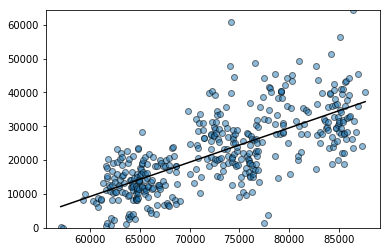

In [12]:
#ALL CATEGORIES
for metric in metriclist:
    groupdf = mergedf.groupby(metric)
    groupdf = groupdf.sum()
    groupdf.reset_index(inplace = True)
    #why are there sum of prices at 0? no data from those dates?
    groupdf = groupdf.loc[groupdf['price'] > 1]


    plt.scatter(groupdf[metric], groupdf['price'], alpha = 0.5, edgecolor = 'black')
    plt.ylim(0, max(groupdf['price']))
    (slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf[metric], groupdf['price'])

    fitBOV = slopeBOV * groupdf[metric] + interceptBOV
    
    plt.plot(groupdf[metric], fitBOV, color = 'black')
    
    print(f'R2 = {round(rBOV**2,2)}')
    print(f'Revenue = {round(slopeBOV, 2)} * (BOVESPA Index) + ({round(interceptBOV,2)})')
    plt.savefig(f'TotalRevenueVsBOV.png')
    plt.show()
    

In [13]:
groupdf.head()

BOV  order_item_id    price  freight_value  product_name_lenght  \
0  57059.0            6.0   134.97           8.49                102.0   
1  57255.0            1.0    10.90           8.72                 64.0   
3  59339.0           89.0  8343.25        1302.69               2629.0   
4  59461.0           81.0  9940.96        1354.52               3256.0   
5  60254.0           70.0  7960.51        1170.72               2750.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                      3108.0                 3.0            3000.0   
1                      1710.0                 1.0             200.0   
3                     45638.0               114.0          147487.0   
4                     55379.0               143.0          164805.0   
5                     44461.0               153.0          122621.0   

   product_length_cm  product_height_cm  product_width_cm  \
0               48.0               48.0              48.0   
1               16.0                2.0              11.0   
3             1651.0             1379.0            1395.0   
4             2293.0             1383.0            1601.0   
5             1769.0              949.0            1244.0   

   customer_zip_code_prefix  geolocation_lat  geolocation_lng    YYYY   MM  
0                     43800       -61.743532      -143.576794    6048   27  
1                     80030       -25.414205       -49.259493    2016   12  
3                   2837569     -1190.278821     -2840.306388  122976  610  
4                   2651925     -1537.803785     -3369.465247  145152  720  
5                   2246322     -1307.756689     -2770.348908  120960  600

In [14]:
newgroup = mergedf.groupby(['category','month'])['price'].sum()
newgroup

category               month
appliances             01/17      4611.16
                       01/18     31172.44
                       02/17     11038.68
                       02/18     26138.97
                       03/17     23442.07
                       03/18     42187.17
                       04/17     19720.41
                       04/18     62834.02
                       05/17     11393.94
                       05/18     45988.51
                       06/17     15598.45
                       06/18     34732.67
                       07/17     11376.11
                       07/18     34224.70
                       08/17     16614.71
                       08/18     29265.18
                       09/17     16602.68
                       10/16      1707.09
                       10/17     13864.92
                       11/17     18497.81
                       12/17     12205.94
auto                   01/17      5629.53
                       01/18     36809.85
     

In [15]:
newgroup = newgroup.unstack(level=-1)


In [16]:
newgroup = newgroup[['01/17','02/17','03/17','04/17','05/17','06/17','07/17','08/17','09/17','10/17','11/17','12/17','01/18','02/18','03/18','04/18','05/18','06/18','07/18','08/18','09/18']]

#cols = list(newgroup.columns.values)
newgroup.head()




month                       01/17     02/17     03/17     04/17     05/17  \
category                                                                    
appliances                4611.16  11038.68  23442.07  19720.41  11393.94   
auto                      5629.53  13206.70  14578.76  15116.07  18585.04   
books                      284.79    980.81   2723.96   1366.37   1773.47   
construction_tools        8598.65  14858.90  25133.70  22689.13  22872.78   
costruction_tools_garden      NaN    579.98       NaN   1490.21   1577.24   

month                        06/17     07/17     08/17     09/17     10/17  \
category                                                                     
appliances                15598.45  11376.11  16614.71  16602.68  13864.92   
auto                      32290.69  15456.32  18289.43  15226.07  20788.28   
books                      2281.98   1820.50   4357.18   2471.49   1573.30   
construction_tools        17544.86  21543.16  26235.23  28700.46  33420.83   
costruction_tools_garden    434.69    347.58   1286.19    297.50    746.90   

month                     ...       12/17     01/18     02/18     03/18  \
category                  ...                                             
appliances                ...    12205.94  31172.44  26138.97  42187.17   
auto                      ...    38073.47  36809.85  42330.67  45297.57   
books                     ...     3338.19   3904.70   3644.76   3033.40   
construction_tools        ...    40422.00  48244.75  50323.36  49846.12   
costruction_tools_garden  ...      928.90   3927.98   1538.25   2497.23   

month                        04/18     05/18     06/18     07/18     08/18  \
category                                                                     
appliances                62834.02  45988.51  34732.67  34224.70  29265.18   
auto                      48852.83  39811.36  45337.18  43812.92  45132.97   
books                      8259.08   8871.05   5532.99   6694.84   3689.77   
construction_tools        65509.44  81974.52  57330.70  57565.52  56595.88   
costruction_tools_garden   1326.79   1121.27    751.45   2836.37   2808.86   

month                     09/18  
category                         
appliances                  NaN  
auto                        NaN  
books                       NaN  
construction_tools          NaN  
costruction_tools_garden    NaN  

[5 rows x 21 columns]

In [17]:
newgroup.drop(['09/18'], axis=1).head()

month                       01/17     02/17     03/17     04/17     05/17  \
category                                                                    
appliances                4611.16  11038.68  23442.07  19720.41  11393.94   
auto                      5629.53  13206.70  14578.76  15116.07  18585.04   
books                      284.79    980.81   2723.96   1366.37   1773.47   
construction_tools        8598.65  14858.90  25133.70  22689.13  22872.78   
costruction_tools_garden      NaN    579.98       NaN   1490.21   1577.24   

month                        06/17     07/17     08/17     09/17     10/17  \
category                                                                     
appliances                15598.45  11376.11  16614.71  16602.68  13864.92   
auto                      32290.69  15456.32  18289.43  15226.07  20788.28   
books                      2281.98   1820.50   4357.18   2471.49   1573.30   
construction_tools        17544.86  21543.16  26235.23  28700.46  33420.83   
costruction_tools_garden    434.69    347.58   1286.19    297.50    746.90   

month                        11/17     12/17     01/18     02/18     03/18  \
category                                                                     
appliances                18497.81  12205.94  31172.44  26138.97  42187.17   
auto                      31466.98  38073.47  36809.85  42330.67  45297.57   
books                      3099.17   3338.19   3904.70   3644.76   3033.40   
construction_tools        55732.93  40422.00  48244.75  50323.36  49846.12   
costruction_tools_garden   1150.60    928.90   3927.98   1538.25   2497.23   

month                        04/18     05/18     06/18     07/18     08/18  
category                                                                    
appliances                62834.02  45988.51  34732.67  34224.70  29265.18  
auto                      48852.83  39811.36  45337.18  43812.92  45132.97  
books                      8259.08   8871.05   5532.99   6694.84   3689.77  
construction_tools        65509.44  81974.52  57330.70  57565.52  56595.88  
costruction_tools_garden   1326.79   1121.27    751.45   2836.37   2808.86

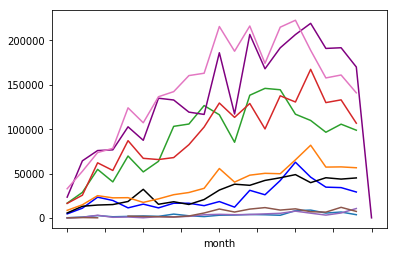

In [18]:
appliances_line = newgroup.iloc[0]
appliances_line.plot(kind='line', color='blue')

auto_line = newgroup.iloc[1]
auto_line.plot(kind='line', color ='black')

books_line = newgroup.iloc[2]
books_line.plot(kind='line')

construction_tools_line = newgroup.iloc[3]
construction_tools_line.plot(kind='line')

electronics_line = newgroup.iloc[7]
electronics_line.plot(kind='line')

fashion_clothing_line = newgroup.iloc[8]
fashion_clothing_line.plot(kind='line')

food_drink_line = newgroup.iloc[11]
food_drink_line.plot(kind='line')

home_furniture_line = newgroup.iloc[14]
home_furniture_line.plot(kind='line', color ='purple')

industry_line = newgroup.iloc[15]
industry_line.plot(kind='line')

other_line = newgroup.iloc[16]
other_line.plot(kind='line')

plt.savefig('./Graphs/CategoricalLineGraph.png')

plt.show()